In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !cp /content/drive/MyDrive/DeepDiveAI-Project-2025/EmotionDataset.zip /content/
# !unzip "/content/drive/MyDrive/DeepDiveAI-Project-2025/EmotionDataset.zip" -d "/content/"
# !rm --recursive /content/EmotionDataset/
#=============================================

target_dir = "/content/EmotionDataset"

import shutil, os

if os.path.exists(target_dir):
    shutil.rmtree(target_dir)

os.makedirs(target_dir, exist_ok=True)

!unzip "/content/drive/MyDrive/DeepDiveAI-Project-2025/EmotionDataset.zip" -d "{target_dir}"
# !unzip "/content/drive/MyDrive/DeepDiveAI-Project-2025/archive.zip" -d "{target_dir}"

Streaming output truncated to the last 5000 lines.
  inflating: /content/EmotionDataset/train/sad/im37.png  
  inflating: /content/EmotionDataset/train/sad/im370.png  
  inflating: /content/EmotionDataset/train/sad/im3700.png  
  inflating: /content/EmotionDataset/train/sad/im3701.png  
  inflating: /content/EmotionDataset/train/sad/im3702.png  
  inflating: /content/EmotionDataset/train/sad/im3703.png  
  inflating: /content/EmotionDataset/train/sad/im3704.png  
  inflating: /content/EmotionDataset/train/sad/im3705.png  
  inflating: /content/EmotionDataset/train/sad/im3706.png  
  inflating: /content/EmotionDataset/train/sad/im3707.png  
  inflating: /content/EmotionDataset/train/sad/im3708.png  
  inflating: /content/EmotionDataset/train/sad/im3709.png  
  inflating: /content/EmotionDataset/train/sad/im371.png  
  inflating: /content/EmotionDataset/train/sad/im3710.png  
  inflating: /content/EmotionDataset/train/sad/im3711.png  
  inflating: /content/EmotionDataset/train/sad/im3712

In [3]:
# FOR NEW DATASET WITH COLOR
print("Train subfolder structure\n")
new_dir = "/content/EmotionDataset/fane_data"

for label in os.listdir(new_dir):
    label_path = os.path.join(new_dir, label)
    if os.path.isdir(label_path):
        num_files = len(os.listdir(label_path))
        print(f"{label}: {num_files} files")

Train subfolder structure



FileNotFoundError: [Errno 2] No such file or directory: '/content/EmotionDataset/fane_data'

In [4]:
# FOR OLD DATASET (BLACK AND WHITE)

print("Train subfolder structure\n")
train_dir = "/content/EmotionDataset/train"

for label in os.listdir(train_dir):
    label_path = os.path.join(train_dir, label)
    if os.path.isdir(label_path):
        num_files = len(os.listdir(label_path))
        print(f"{label}: {num_files} files")

print("\n========================================\n")

print("Test subfolder structure\n")
test_dir = "/content/EmotionDataset/test"

for label in os.listdir(test_dir):
    label_path = os.path.join(test_dir, label)
    if os.path.isdir(label_path):
        num_files = len(os.listdir(label_path))
        print(f"{label}: {num_files} files")

Train subfolder structure

sad: 4830 files
disgusted: 436 files
surprised: 3171 files
fearful: 4097 files
happy: 7215 files
neutral: 4965 files
angry: 3995 files


Test subfolder structure

sad: 1247 files
disgusted: 111 files
surprised: 831 files
fearful: 1024 files
happy: 1774 files
neutral: 1233 files
angry: 958 files


In [ ]:
# import os
# os.kill(os.getpid(), 9)  # this forces runtime restart in Colab

In [ ]:
import os, shutil
from sklearn.model_selection import train_test_split

# Original flat dataset path
original_data_dir = "/content/EmotionDataset/fane_data"
new_data_dir = "/content/EmotionDataset"

# New target directories
train_dir = os.path.join(new_data_dir, "train")
test_dir = os.path.join(new_data_dir, "test")

# Collect all image paths and labels
images, labels = [], []
for label in os.listdir(original_data_dir):
    label_path = os.path.join(original_data_dir, label)
    if os.path.isdir(label_path) and label not in ["train", "test"]:
        for fname in os.listdir(label_path):
            if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                images.append(os.path.join(label_path, fname))
                labels.append(label)

# Train/test split
train_imgs, test_imgs, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=42
)

# Helper to copy to new structure
def copy_to_split(img_paths, lbls, split_dir):
    for img, lbl in zip(img_paths, lbls):
        dest_dir = os.path.join(split_dir, lbl)
        os.makedirs(dest_dir, exist_ok=True)
        shutil.copy(img, os.path.join(dest_dir, os.path.basename(img)))

# Run the move
copy_to_split(train_imgs, train_labels, train_dir)
copy_to_split(test_imgs, test_labels, test_dir)


!rm --recursive /content/EmotionDataset/fane_data/
print("✅ Dataset successfully split into /train and /test folders.")


✅ Dataset successfully split into /train and /test folders.


In [ ]:
import os
from PIL import Image, UnidentifiedImageError

def remove_corrupted_images(root_dir):
    extensions = ['.jpg', '.jpeg', '.png']
    removed_files = []

    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if os.path.splitext(file)[1].lower() in extensions:
                file_path = os.path.join(subdir, file)
                try:
                    with Image.open(file_path) as img:
                        img.verify()  # Verify that it is, indeed an image
                except (UnidentifiedImageError, OSError) as e:
                    print(f"Removing corrupted image: {file_path}")
                    os.remove(file_path)
                    removed_files.append(file_path)

    print(f"Total corrupted images removed: {len(removed_files)}")

# Call it on your dataset path (test and train folders)
remove_corrupted_images('/content/EmotionDataset/train')
remove_corrupted_images('/content/EmotionDataset/test')


Total corrupted images removed: 0
Removing corrupted image: /content/EmotionDataset/test/happy/happy1283.jpg
Total corrupted images removed: 1


In [5]:
# image_loader.py
import os
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Subset, random_split, DataLoader
import timm
from torchvision.datasets import ImageFolder

def get_image_dataloaders(dataset_path, batch_size, num_workers, loadNumImages=-1, model_name='resnet50.a1_in1k'):
    if model_name == 'custom':
        # Use basic transforms for custom CNN
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3),
        ])
    elif model_name == 'resnet50.a1_in1k':
        # Load model-specific transform
        model = timm.create_model(model_name, pretrained=True, num_classes=0)
        data_config = timm.data.resolve_model_data_config(model)
        # transform = timm.data.create_transform(**data_config, is_training=False)
        # train_transform = timm.data.create_transform(**data_config, is_training=True)
        # test_transform = timm.data.create_transform(**data_config, is_training=False)

        train_transform = transforms.Compose([
            #NEW LINE (TEMPORARY TEST)
            transforms.Lambda(lambda img: img.convert("RGB")),  # 👈 Force grayscale to 3-channel

            transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),  # More aggressive cropping
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
                transforms.RandomAffine(20, translate=(0.15, 0.15), scale=(0.8, 1.2)),
                transforms.RandomPerspective(distortion_scale=0.2, p=0.5)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize(data_config['mean'], data_config['std']),
            transforms.RandomErasing(p=0.5, scale=(0.02, 0.1), value='random'),  # New
        ])

        test_transform = transforms.Compose([
            #NEW LINE
            transforms.Lambda(lambda img: img.convert("RGB")),  # 👈 This line is essential

            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(data_config['mean'], data_config['std']),
        ])

    else:
        return ValueError("Model not found")

    def limit_dataset(dataset):
        if loadNumImages <= 0:
            return dataset

        # Ensure balanced sampling
        class_counts = {i: 0 for i in range(len(dataset.classes))}
        indices = []

        for idx, (_, label_idx) in enumerate(dataset.samples):
            if class_counts[label_idx] < loadNumImages:
                indices.append(idx)
                class_counts[label_idx] += 1

        return Subset(dataset, indices)

    train_path = os.path.join(dataset_path, 'train')
    test_path = os.path.join(dataset_path, 'test')

    train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
    test_dataset = datasets.ImageFolder(test_path, transform=test_transform)

    train_dataset = limit_dataset(train_dataset)
    test_dataset = limit_dataset(test_dataset)


    # Yo Ron, if you could somehow figure out how to load in the new dataset that would definately improve the model's performance. I don't know how to do that cause when I tried to, the training process took forever. It might be due to how I split the data, or due to the high resolution of the images.

    # ======= UPDATED STRUCTURE HANDLING =======
    # train_path = os.path.join(dataset_path, 'train')
    # test_path = os.path.join(dataset_path, 'test')

    # if os.path.isdir(train_path) and os.path.isdir(test_path):
    #     # Old format
    #     train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
    #     test_dataset = datasets.ImageFolder(test_path, transform=test_transform)
    # elif os.path.isdir(os.path.join(dataset_path, 'fane_data')):
    #     # NEW: Handle fane_data structure
    #     class_root = os.path.join(dataset_path, 'fane_data')
    #     # full_dataset = datasets.ImageFolder(class_root, transform=train_transform)
    #     train_dataset = SafeImageFolder(train_path, transform=train_transform)
    #     test_dataset = SafeImageFolder(test_path, transform=test_transform)

    #     full_dataset = SafeImageFolder(class_root, transform=train_transform)

    #     # Remove bad samples
    #     full_dataset.samples = [s for s in full_dataset.samples
    #                           if os.path.splitext(s[0])[1].lower() in ['.jpg', '.jpeg', '.png']]

    #     # 80/20 split
    #     total_len = len(full_dataset)
    #     train_len = int(0.8 * total_len)
    #     test_len = total_len - train_len
    #     train_dataset, test_dataset = random_split(
    #         full_dataset, [train_len, test_len],
    #         generator=torch.Generator().manual_seed(42)
    #     )

    #     # Apply test transform
    #     test_dataset.dataset.transform = test_transform

    # train_dataset = limit_dataset(train_dataset)
    # test_dataset = limit_dataset(test_dataset)

    # ======= HANDLE STRUCTURE =======
    # train_path = os.path.join(dataset_path, 'train')
    # test_path = os.path.join(dataset_path, 'test')

    # if os.path.isdir(train_path) and os.path.isdir(test_path):
    #     # Old format
    #     train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
    #     test_dataset = datasets.ImageFolder(test_path, transform=test_transform)

    #     train_dataset = limit_dataset(train_dataset)
    #     test_dataset = limit_dataset(test_dataset)
    # else:
    #     # New flat format: load everything and split

    #     full_dataset = datasets.ImageFolder(dataset_path, transform=train_transform)

    #     # Remove bad samples
    #     full_dataset.samples = [s for s in full_dataset.samples if os.path.splitext(s[0])[1].lower() in ['.jpg', '.jpeg', '.png']]

    #     # 80/20 split
    #     total_len = len(full_dataset)
    #     train_len = int(0.8 * total_len)
    #     test_len = total_len - train_len

    #     train_dataset, test_dataset = random_split(full_dataset, [train_len, test_len], generator=torch.Generator().manual_seed(42))

    #     # Fix test transform
    #     test_dataset.dataset.transform = test_transform

    #     train_dataset = limit_dataset(train_dataset)
    #     test_dataset = limit_dataset(test_dataset)

    #pin_memory is new
    pin = torch.cuda.is_available()
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin)

    return train_loader, test_loader


In [15]:
# trainer.py
import os, torch
import torch.nn as nn
import torch.nn.functional as F
# from model import EmotionNet
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output
from sklearn.metrics import f1_score

import timm
# from model import MoodCNN  # <- this is your custom model, no timm


class Trainer:
    def __init__(self, args, train_loader=None, epoch=1):
        self.args = args
        self.epoch = args.epochs

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        if args.model_name == 'custom':
            self.model = MoodCNN2(num_classes=args.num_classes).to(self.device)
        elif args.model_name == 'resnet50.a1_in1k':
            backbone = timm.create_model(args.model_name, pretrained=True, num_classes=0)
            self.model = EmotionNet(backbone, args.num_classes).to(self.device)
        else:
            raise ValueError("Model not found")

        # self.optimizer = torch.optim.Adam(self.model.parameters(), lr=args.lr)
        # self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=args.lr_decay)
        # self.criterion = nn.CrossEntropyLoss()

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=args.lr_decay)
        self.criterion = nn.CrossEntropyLoss()

        # Logging DataFrame
        self.logs_df = pd.DataFrame(columns=["Epoch", "Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy", "F1 Score"])


    def train_network(self, epoch, loader, **kwargs):
        self.model.train()
        total_loss, correct, total = 0, 0, 0

        loop = tqdm(loader, desc=f"Epoch {epoch} [Training]", leave=False)
        for imgs, labels in loop:
            imgs, labels = imgs.to(self.device), labels.to(self.device)

            outputs = self.model(imgs)
            loss = self.criterion(outputs, labels)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(loss=loss.item())

        self.scheduler.step()
        avg_loss = total_loss / len(loader)
        accuracy = (correct / total) * 100.0
        return avg_loss, accuracy, self.optimizer.param_groups[0]['lr']

    def get_classes(self, dataset):
        while hasattr(dataset, 'dataset'):
            dataset = dataset.dataset
        return getattr(dataset, 'classes', None)

    def evaluate_network(self, epoch=0, loader=None, **kwargs):
        self.model.eval()
        #for avg_loss and accuracy
        correct, total, total_loss = 0, 0, 0

        #for f1 score
        all_preds, all_labels = [], []

        loop = tqdm(loader, desc=f"Epoch {epoch} [Evaluating]", leave=False)
        with torch.no_grad():
            for imgs, labels in loader:
                imgs, labels = imgs.to(self.device), labels.to(self.device)
                outputs = self.model(imgs)
                loss = self.criterion(outputs, labels)

                predicted = torch.argmax(outputs, dim=1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                total_loss += loss.item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                loop.set_postfix(accuracy=f"{(correct/total)*100:.2f}%")

        avg_loss = total_loss / len(loader)
        accuracy = (correct / total) * 100.0
        f1 = f1_score(all_labels, all_preds, average='weighted') * 100.0

        # Add confusion matrix
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 8))
        classes = self.get_classes(loader.dataset)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=classes,
                    yticklabels=classes)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

        return avg_loss, accuracy, f1

    def log_metrics(self, epoch, train_loss, train_acc, val_loss, val_acc, f1):
        new_row = {
            "Epoch": epoch,
            "Train Loss": train_loss,
            "Train Accuracy": train_acc,
            "Val Loss": val_loss,
            "Val Accuracy": val_acc,
            "F1 Score": f1
        }
        self.logs_df = pd.concat([self.logs_df, pd.DataFrame([new_row])], ignore_index=True)
        display(self.logs_df.tail(10))  # display last 10 entries for readability in Colab

    def plot_metrics(self):
        sns.set(style="whitegrid")
        fig, axes = plt.subplots(1, 2, figsize=(18, 6))

        # Plot Loss (Train + Validation)
        axes[0].set_title(f"Model Loss - {self.args.model_name}", fontsize=14)
        sns.lineplot(ax=axes[0], x="Epoch", y="Train Loss", data=self.logs_df, label="Train Loss", marker="o")
        sns.lineplot(ax=axes[0], x="Epoch", y="Val Loss", data=self.logs_df, label="Val Loss", marker="o")
        axes[0].set_xlabel("Epoch")
        axes[0].set_ylabel("Loss")
        axes[0].legend()

        # Plot Accuracy + F1
        axes[1].set_title(f"Accuracy & F1 Score - {self.args.model_name}", fontsize=14)
        sns.lineplot(ax=axes[1], x="Epoch", y="Train Accuracy", data=self.logs_df, label="Train Accuracy", marker="o")
        sns.lineplot(ax=axes[1], x="Epoch", y="Val Accuracy", data=self.logs_df, label="Val Accuracy", marker="o")
        sns.lineplot(ax=axes[1], x="Epoch", y="F1 Score", data=self.logs_df, label="F1 Score", marker="o")

        # Highlight max points
        max_acc_idx = self.logs_df["Val Accuracy"].idxmax()
        max_f1_idx = self.logs_df["F1 Score"].idxmax()
        acc_x = self.logs_df.loc[max_acc_idx, "Epoch"]
        acc_y = self.logs_df.loc[max_acc_idx, "Val Accuracy"]
        f1_x = self.logs_df.loc[max_f1_idx, "Epoch"]
        f1_y = self.logs_df.loc[max_f1_idx, "F1 Score"]

        axes[1].plot(acc_x, acc_y, "ro")
        axes[1].text(acc_x, acc_y + 0.5, f"Max Val Acc: {acc_y:.2f}%", color="red")

        axes[1].plot(f1_x, f1_y, "go")
        axes[1].text(f1_x, f1_y + 0.5, f"Max F1: {f1_y:.2f}%", color="green")

        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Score (%)")
        axes[1].legend()

        plt.tight_layout()
        plt.show()

    def saveParameters(self, path):
        torch.save(self.model.state_dict(), path)

    def loadParameters(self, path):
        self.model.load_state_dict(torch.load(path, map_location=self.device))


In [16]:
# model.py
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from urllib.request import urlopen
import timm

from tqdm import tqdm
import time

#Using pretrained resnet50.a1_in1k model as a feature extractor, without classifier head
backbone_model = timm.create_model(
    'resnet50.a1_in1k',
    pretrained=True,
    num_classes = 0,
)

# effNet = timm.create_model(
#     "efficientnetv2_m.in21k_ft_in1k",
#     pretrained=True,
#     num_classes = 7
# )


class MoodCNN1(nn.Module):
    def __init__(self, num_classes=7):
        super(MoodCNN1, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 112x112

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 56x56

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

# Increase capacity and add residual connections
class MoodCNN2(nn.Module):
    def __init__(self, num_classes=7):
        super(MoodCNN2, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.res1 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128)
        )

        self.conv2 = nn.Sequential(
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.res2 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256)
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        res = x
        x = self.res1(x)
        x += F.interpolate(res, scale_factor=1, mode='nearest')  # Skip connection
        x = self.conv2(x)
        res = x
        x = self.res2(x)
        x += res  # Skip connection
        return self.classifier(x)


class EmotionNet(nn.Module):
    def __init__(self, backbone, num_classes):
        super(EmotionNet, self).__init__()
        self.backbone = backbone
        self.classifier = nn.Linear(backbone.num_features, num_classes)
        self.classifier = nn.Sequential(
            # nn.Dropout(0.3),
            # nn.Linear(backbone.num_features, 512),
            # nn.ReLU(inplace=True),
            # nn.Dropout(0.3),
            # nn.Linear(512, num_classes)

            nn.BatchNorm1d(backbone.num_features),
            nn.Dropout(0.5),
            nn.Linear(backbone.num_features, 512),
            nn.SiLU(inplace=True),  # Better activation
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        return self.classifier(x)

In [17]:
# Define global persistent path to save best.model
GLOBAL_MODEL_PATH = "/content/drive/MyDrive/emotion_model/best.model"

# Patch in a persistent model path default (global best model)
def get_best_model_path():
    return "/content/drive/MyDrive/emotion_model/best.model"

Resuming from best model: /content/drive/MyDrive/emotion_model/best.model


Epoch 1 [Evaluating]:   0%|          | 0/113 [00:11<?, ?it/s, accuracy=69.31%]

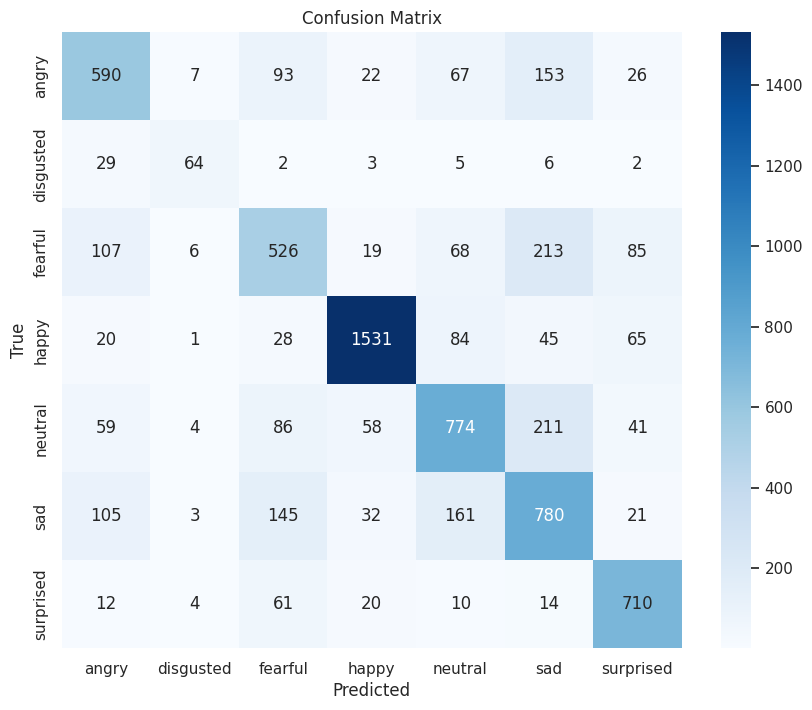

2025-07-26 02:10:04 1 epoch, LR 0.000950, LOSS 0.5972, Val Acc 69.31%, F1 69.34%, Best Acc 69.66%


Epoch 2 [Evaluating]:   0%|          | 0/113 [00:11<?, ?it/s, accuracy=70.05%]

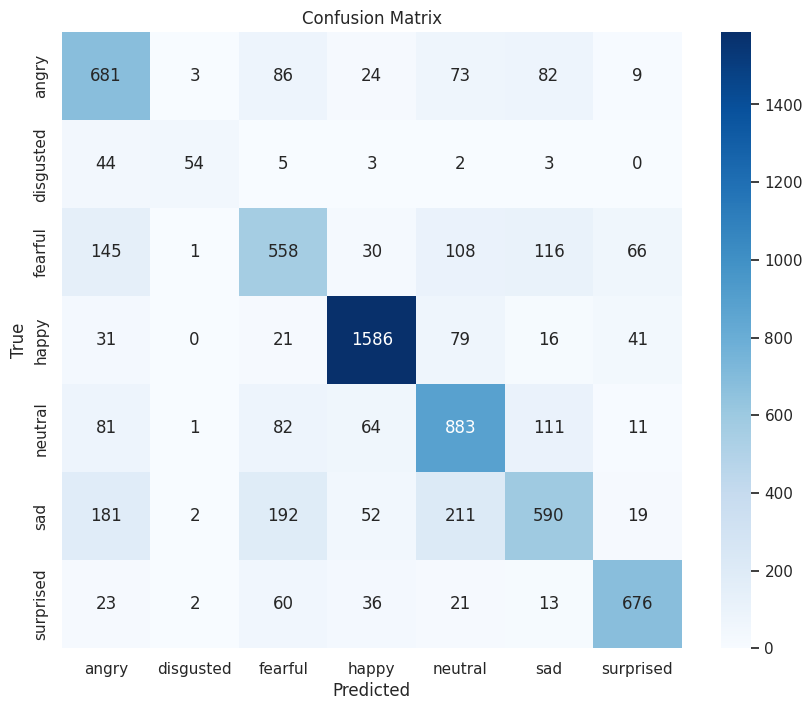

New best model copied to Google Drive at /content/drive/MyDrive/emotion_model/best.model
2025-07-26 02:12:36 2 epoch, LR 0.000902, LOSS 0.5671, Val Acc 70.05%, F1 69.76%, Best Acc 70.05%


Epoch 3 [Evaluating]:   0%|          | 0/113 [00:11<?, ?it/s, accuracy=69.23%]

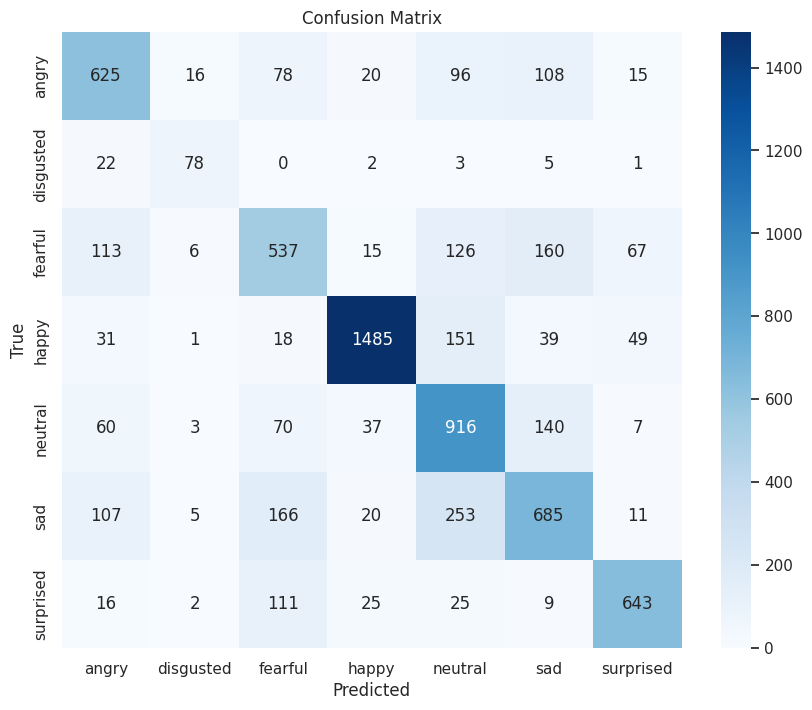

2025-07-26 02:15:08 3 epoch, LR 0.000857, LOSS 0.5555, Val Acc 69.23%, F1 69.44%, Best Acc 70.05%


Epoch 4 [Evaluating]:   0%|          | 0/113 [00:11<?, ?it/s, accuracy=70.08%]

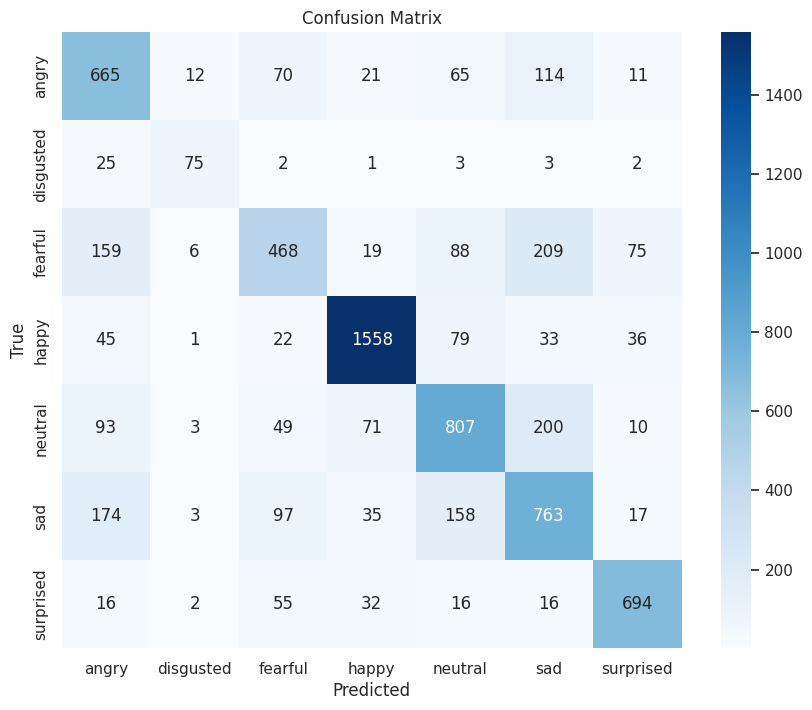

New best model copied to Google Drive at /content/drive/MyDrive/emotion_model/best.model
2025-07-26 02:17:41 4 epoch, LR 0.000815, LOSS 0.5327, Val Acc 70.08%, F1 69.97%, Best Acc 70.08%


Epoch 5 [Evaluating]:   0%|          | 0/113 [00:11<?, ?it/s, accuracy=68.96%]

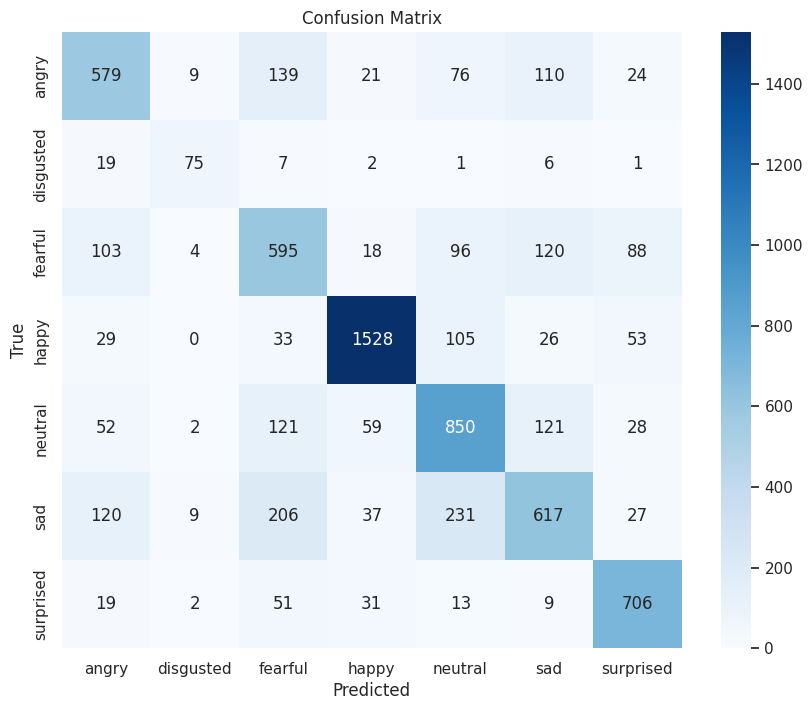

2025-07-26 02:20:13 5 epoch, LR 0.000774, LOSS 0.5105, Val Acc 68.96%, F1 68.90%, Best Acc 70.08%


Epoch 6 [Evaluating]:   0%|          | 0/113 [00:11<?, ?it/s, accuracy=70.13%]

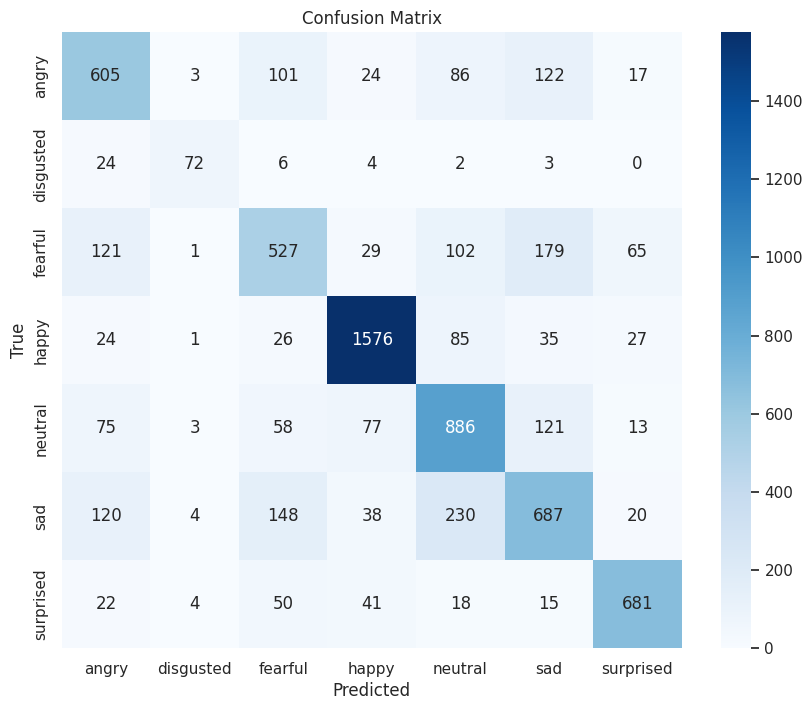

New best model copied to Google Drive at /content/drive/MyDrive/emotion_model/best.model
2025-07-26 02:22:46 6 epoch, LR 0.000735, LOSS 0.4937, Val Acc 70.13%, F1 69.98%, Best Acc 70.13%


Epoch 7 [Evaluating]:   0%|          | 0/113 [00:11<?, ?it/s, accuracy=70.69%]

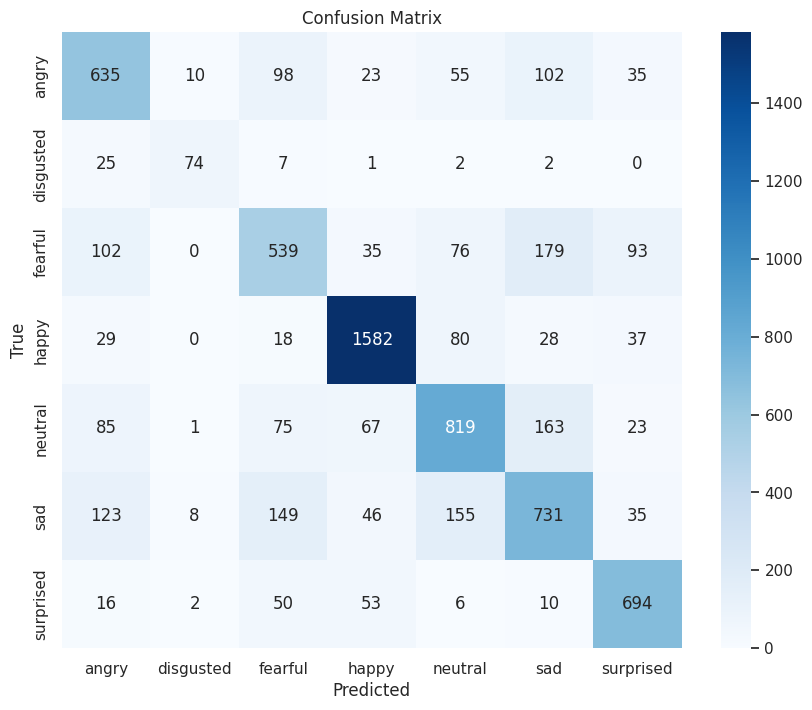

New best model copied to Google Drive at /content/drive/MyDrive/emotion_model/best.model
2025-07-26 02:25:19 7 epoch, LR 0.000698, LOSS 0.4590, Val Acc 70.69%, F1 70.49%, Best Acc 70.69%


Epoch 8 [Evaluating]:   0%|          | 0/113 [00:11<?, ?it/s, accuracy=69.71%]

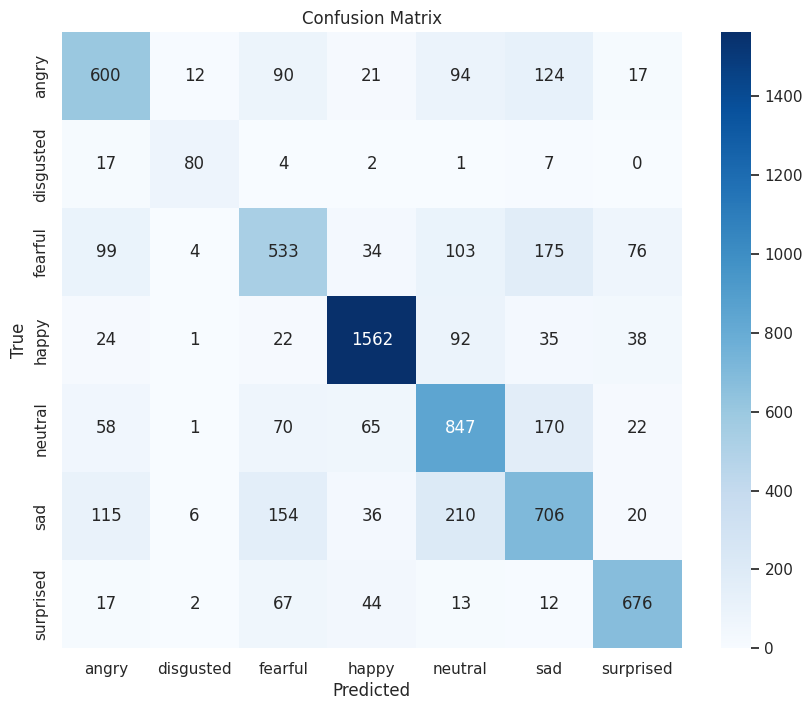

2025-07-26 02:27:51 8 epoch, LR 0.000663, LOSS 0.4379, Val Acc 69.71%, F1 69.63%, Best Acc 70.69%


Epoch 9 [Evaluating]:   0%|          | 0/113 [00:11<?, ?it/s, accuracy=70.40%]

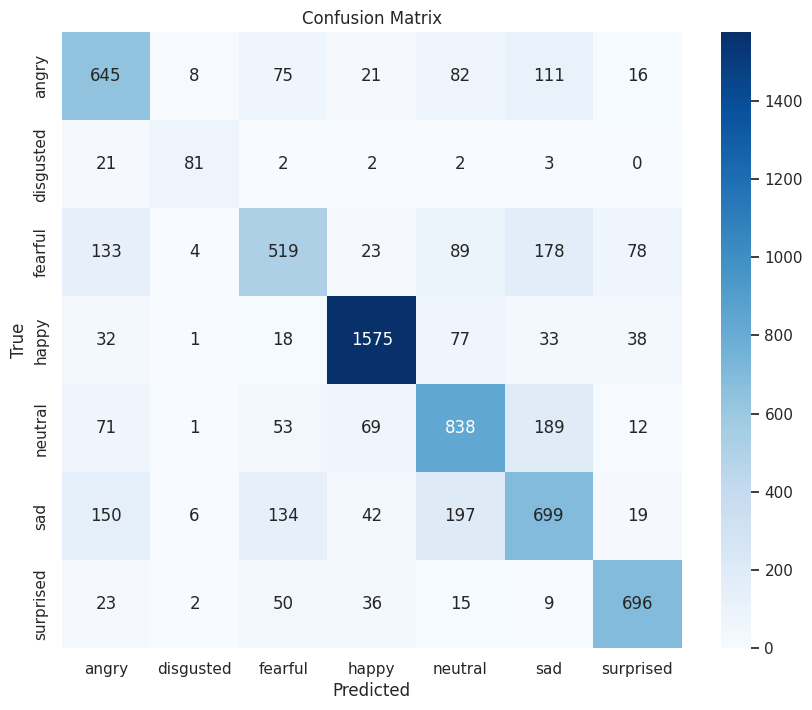

2025-07-26 02:30:24 9 epoch, LR 0.000630, LOSS 0.4262, Val Acc 70.40%, F1 70.25%, Best Acc 70.69%


Epoch 10 [Evaluating]:   0%|          | 0/113 [00:11<?, ?it/s, accuracy=69.99%]

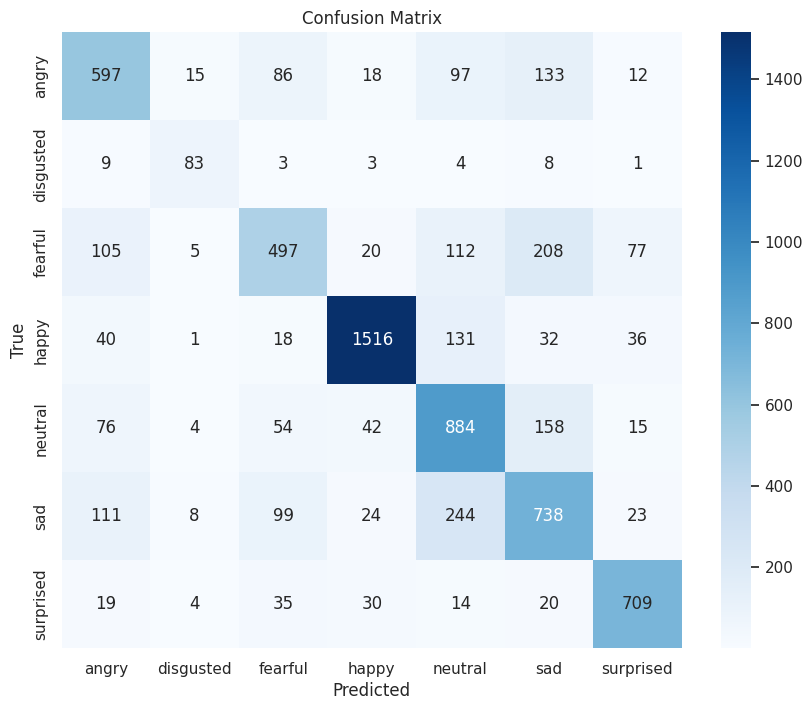

2025-07-26 02:32:56 10 epoch, LR 0.000599, LOSS 0.4024, Val Acc 69.99%, F1 69.99%, Best Acc 70.69%


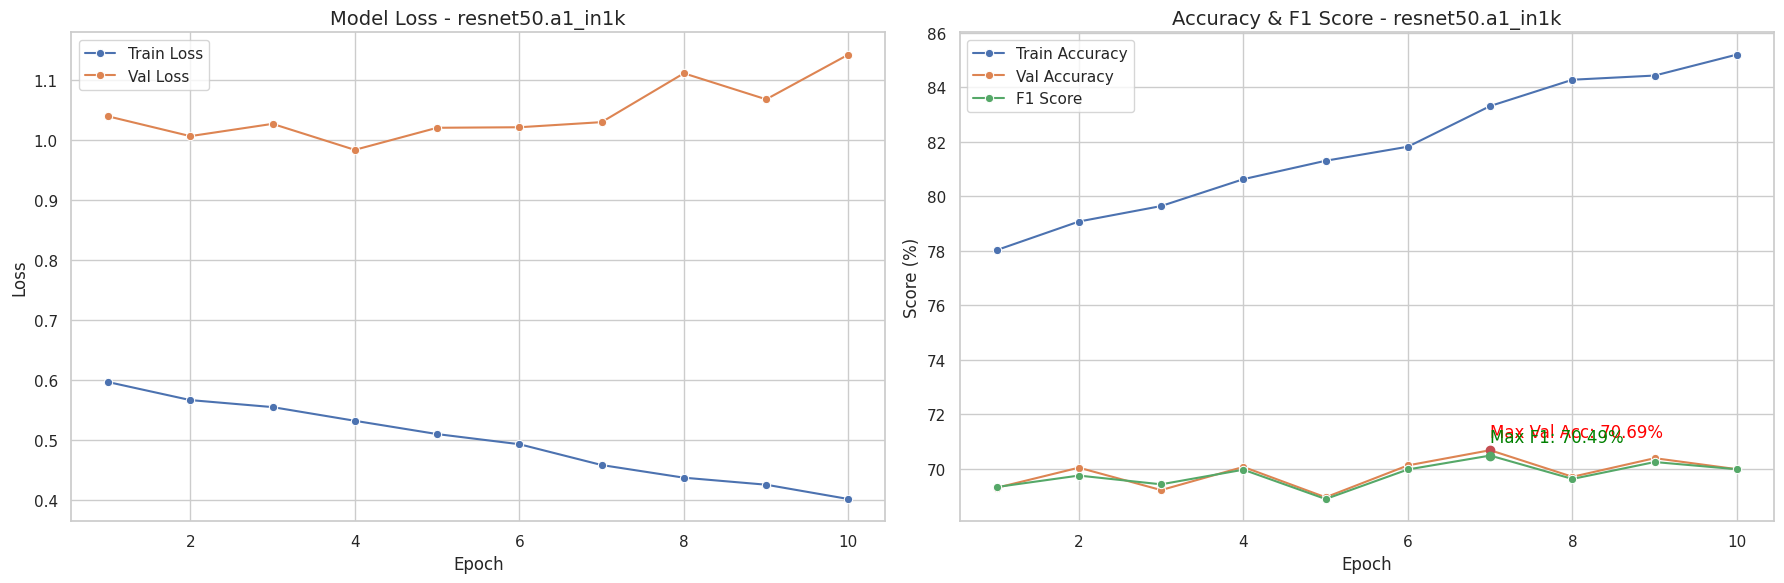

In [20]:
# main.py
import argparse, os, glob, time, sys
# from trainer import Trainer
# from image_loader import get_image_dataloaders
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from IPython.display import display, clear_output

def get_args():
    parser = argparse.ArgumentParser()

    parser.add_argument('--model_name', type=str, default='resnet50.a1_in1k', help="Backbone model name from timm")
    parser.add_argument('--num_classes', type=int, default=7, help="Number of emotion classes")
    parser.add_argument("--loadNumImages", type=int, default=-1, help="Max images to load per class. Use -1 to load all.")
    parser.add_argument('--batch_size', type=int, default=64)
    parser.add_argument('--num_workers', type=int, default=2) #4 is too much for google colab to handle
    parser.add_argument('--lr', type=float, default=1e-3)
    parser.add_argument('--lr_decay', type=float, default=0.95)
    parser.add_argument('--weight_decay', type=float, default=1e-3)
    parser.add_argument('--epochs', type=int, default=10)
    parser.add_argument('--dataset_path', type=str, default='/content/EmotionDataset')
    parser.add_argument('--savePath', type=str, default='checkpoints')
    parser.add_argument('--testInterval', type=int, default=1)
    parser.add_argument('--evaluation', action='store_true')
    parser.add_argument('--eval_model_path', type=str, default=get_best_model_path())
    parser.add_argument('--freeze_params', type=bool, default=True)
    parser.add_argument('--resume', type=bool, default=True, help="If set, resume from best model checkpoint in Google Drive")

    # return parser.parse_args()

    # Check if we're in an interactive environment like Colab
    if hasattr(sys, 'ps1') or 'ipykernel' in sys.modules:
        return parser.parse_args(args=[])
    else:
        return parser.parse_args()

def get_last_best_accuracy(score_path):
    try:
        if os.path.exists(score_path):
            with open(score_path, "r") as f:
                lines = f.readlines()
                if lines:
                    last_line = lines[-1]
                    for part in last_line.strip().split(","):
                        if "Best Acc" in part:
                            return float(part.strip().split(" ")[-1].replace("%", ""))
    except Exception as e:
        print("Error reading previous best accuracy:", e)
    return 0



def main(args):
    trainLoader, valLoader = get_image_dataloaders(
        dataset_path=args.dataset_path,
        batch_size=args.batch_size,
        num_workers=args.num_workers,
        loadNumImages=args.loadNumImages,
        model_name=args.model_name
    )

    # if args.evaluation:
    #     s = Trainer(args)
    #     if args.eval_model_path == "path not specified":
    #         print("Evaluation model parameters path has not been specified")
    #         return
    #     s.loadParameters(args.eval_model_path)
    #     print("Parameters loaded from path", args.eval_model_path)
    #     val_avg_loss, val_accuracy, val_f1 = s.evaluate_network(loader=valLoader)
    #     print(f"Eval - Val Loss: {val_avg_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, F1 Score: {val_f1:.2f}")
    #     return
    if args.evaluation:
        s = Trainer(args)

        # Auto-load best.model if no eval_model_path is explicitly set
        if args.eval_model_path == "path not specified":
            best_model_path = os.path.join(args.savePath, "model", "best.model")
            if os.path.exists(best_model_path):
                args.eval_model_path = best_model_path
                print(f"Auto-loading best model from {args.eval_model_path}")
            else:
                print("Evaluation model path not specified and best.model does not exist.")
                return

        s.loadParameters(args.eval_model_path)
        print("Parameters loaded from path", args.eval_model_path)

    args.modelSavePath = os.path.join(args.savePath, 'model')
    os.makedirs(args.modelSavePath, exist_ok=True)
    args.scoreSavePath = os.path.join(args.savePath, 'score.txt')



    # If resume is explicitly requested, load from best.model in Google Drive
    if args.resume:
        epoch = 1
        s = Trainer(args, epoch=epoch)
        best_model_path = get_best_model_path()
        if os.path.exists(best_model_path):
            print(f"Resuming from best model: {best_model_path}")
            s.loadParameters(best_model_path)
        else:
            print(f"Resume requested, but model not found at: {best_model_path}. Starting from scratch.")
    else:

        modelfiles = glob.glob('%s/model_0*.model' % args.modelSavePath)
        # modelfiles += glob.glob(f'{args.modelSavePath}/best.model')  # Add this line
        modelfiles.sort()

        if len(modelfiles) >= 1:
            print("Model %s loaded from previous state!" % modelfiles[-1])
            epoch = int(os.path.splitext(os.path.basename(modelfiles[-1]))[0][6:]) + 1
            s = Trainer(args, epoch=epoch)
            s.loadParameters(modelfiles[-1])
        else:
            epoch = 1
            s = Trainer(args, epoch=epoch)

            if args.resume:
                best_model_path = get_best_model_path()
                if os.path.exists(best_model_path):
                    print(f"Resuming from best model: {best_model_path}")
                    s.loadParameters(best_model_path)
                else:
                    print(f"Resume requested, but model not found at: {best_model_path}. Starting from scratch.")
            else:
                print("Starting training from scratch")


    mAPs = []
    # bestmAP = 0
    bestmAP = get_last_best_accuracy(args.scoreSavePath)
    scoreFile = open(args.scoreSavePath, "a+")

    while epoch <= args.epochs:
        train_loss, train_acc, lr = s.train_network(epoch=epoch, loader=trainLoader)

        if epoch % args.testInterval == 0:
            val_loss, val_acc, val_f1 = s.evaluate_network(epoch=epoch, loader=valLoader)
            mAP = val_acc  # use validation accuracy as "mAP" proxy
            mAPs.append(mAP)

            # Log metrics to dataframe
            s.logs_df.loc[len(s.logs_df)] = {
                "Epoch": epoch,
                "Train Loss": train_loss,
                "Train Accuracy": train_acc,
                "Val Loss": val_loss,
                "Val Accuracy": val_acc,
                "F1 Score": val_f1
            }

            # Save every epoch's model with a numbered name
            s.saveParameters(f"{args.modelSavePath}/model_{epoch:04d}.model")

            if mAP > bestmAP:
                bestmAP = mAP
                # s.saveParameters(f"{args.modelSavePath}/best.model")
                best_model_path_local = f"{args.modelSavePath}/best.model"
                s.saveParameters(best_model_path_local)

                # Define Google Drive upload path
                drive_model_path = get_best_model_path()

                # Upload to Google Drive only if improved
                os.makedirs(os.path.dirname(drive_model_path), exist_ok=True)
                from shutil import copyfile
                copyfile(best_model_path_local, drive_model_path)

                print(f"New best model copied to Google Drive at {drive_model_path}")

            print(time.strftime("%Y-%m-%d %H:%M:%S"),
                  f"{epoch} epoch, LR {lr:.6f}, LOSS {train_loss:.4f}, "
                  f"Val Acc {val_acc:.2f}%, F1 {val_f1:.2f}%, Best Acc {bestmAP:.2f}%")

            scoreFile.write(
                f"{epoch} epoch, LR {lr:.6f}, LOSS {train_loss:.4f}, "
                f"Val Loss {val_loss:.4f}, Val Acc {val_acc:.2f}%, F1 {val_f1:.2f}%, Best Acc {bestmAP:.2f}%\n"
            )
            scoreFile.flush()

        epoch += 1

    scoreFile.close()
    s.plot_metrics()


if __name__ == "__main__":
    args = get_args()
    main(args)


In [26]:
import torch
import requests
from PIL import Image
from torchvision import transforms
# from model import EmotionNet, MoodCNN2  # your actual model class
import timm
import io

prediction_args = {
    "model_type": 'resnet50.a1_in1k',
    "checkpoint_path": get_best_model_path(),
    "class_names": ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
}

# Step 3: Load model (same constructor and checkpoint path)
model = timm.create_model(prediction_args['model_type'], pretrained=True, num_classes=0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
backbone = timm.create_model(prediction_args['model_type'], pretrained=False, num_classes=0)
model = EmotionNet(backbone, num_classes=len(prediction_args['class_names']))
model.load_state_dict(torch.load(prediction_args['checkpoint_path'], map_location=device))
model.to(device)
model.eval()

def predict_from_url(
    url,
    model_type='resnet50.a1_in1k',
    # checkpoint_path = f'{args.modelSavePath}/best.model',
    checkpoint_path = get_best_model_path(),
    class_names=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
):
    # Step 1: Download and open image
    response = requests.get(url)
    # image = Image.open(io.BytesIO(response.content)).convert("RGB")
    image = Image.open(io.BytesIO(response.content)).convert('L')

    # model = timm.create_model(model_type, pretrained=True, num_classes=0)
    data_config = timm.data.resolve_model_data_config(model)

    transform = transforms.Compose([
        transforms.Lambda(lambda img: img.convert("RGB")),  # 👈 This line is essential
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(data_config['mean'], data_config['std']),
    ])

    # transform = timm.data.create_transform(**data_config, is_training=False)
    # Step 2: Apply same transform as validation
    # transform = transforms.Compose([
    #     transforms.Resize((224, 224)),
    #     transforms.ToTensor(),
    #     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    # ])
    image_tensor = transform(image).unsqueeze(0)  # add batch dimension

    # # Step 3: Load model (same constructor and checkpoint path)
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # backbone = timm.create_model(model_type, pretrained=True, num_classes=0)
    # model = EmotionNet(backbone, num_classes=len(class_names))
    # model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    # model.to(device)
    # model.eval()
    # print(checkpoint_path)

    # Step 4: Inference
    with torch.no_grad():
        output = model(image_tensor.to(device))
        probs = torch.softmax(output, dim=1)
        confidence, predicted = torch.max(probs, dim=1)
        predicted_label = class_names[predicted.item()]

    print(f"Predicted Emotion: {predicted_label} ({confidence.item():.2f})")
    # print(probs)
    return predicted_label, confidence.item()


In [25]:
#Correct
predict_from_url("https://t4.ftcdn.net/jpg/00/56/93/53/360_F_56935312_NiqxkRKOdGSJd86Tc2uLycL9fkUsIlRW.jpg")
predict_from_url("https://t4.ftcdn.net/jpg/00/88/53/89/360_F_88538986_5Bi4eJ667pocsO3BIlbN4fHKz8yUFSuA.jpg")
predict_from_url("https://www.pngall.com/wp-content/uploads/2/Angry-Person-Transparent.png")
predict_from_url("https://images.squarespace-cdn.com/content/v1/5d1ae7b443a4be0001f321b6/c963ccdf-eaea-492f-ae6e-49b35cef0b22/PersonCentred+Psychology.JPG")
predict_from_url("https://t4.ftcdn.net/jpg/00/73/24/39/360_F_73243993_WfQ6CwwVbsSf36W0oLaCseTecG6dQMFm.jpg")

#Incorrect | All should be Angry
predict_from_url("https://www.pngmart.com/files/7/Angry-Person-Transparent-PNG.png")
predict_from_url("https://speakingofsuicide.com/wp-content/uploads/2013/05/angry-asking-about-suicide.jpg")

# Predicted Emotion: angry (0.97)
# Predicted Emotion: happy (1.00)
# Predicted Emotion: angry (0.98)
# Predicted Emotion: angry (0.65)
# Predicted Emotion: angry (0.59)
# Predicted Emotion: sad (0.32)
# Predicted Emotion: happy (0.81)
# ('happy', 0.8105629086494446)

Predicted Emotion: angry (0.97)
tensor([[9.7176e-01, 8.4895e-06, 1.9282e-02, 5.3762e-03, 1.5020e-04, 9.8482e-05,
         3.3238e-03]], device='cuda:0')
Predicted Emotion: happy (0.99)
tensor([[2.9846e-04, 7.5924e-08, 4.7052e-05, 9.9442e-01, 3.1812e-05, 5.4802e-05,
         5.1458e-03]], device='cuda:0')
Predicted Emotion: angry (1.00)
tensor([[9.9579e-01, 2.4424e-05, 2.8387e-03, 2.9892e-05, 2.6735e-05, 1.2495e-03,
         3.7017e-05]], device='cuda:0')
Predicted Emotion: angry (0.74)
tensor([[7.3908e-01, 8.5547e-06, 1.5456e-02, 2.3987e-01, 3.4841e-05, 1.2548e-03,
         4.2965e-03]], device='cuda:0')
Predicted Emotion: angry (0.79)
tensor([[7.8718e-01, 1.8561e-04, 2.8030e-02, 2.3261e-03, 1.1364e-02, 1.6681e-01,
         4.1093e-03]], device='cuda:0')
Predicted Emotion: neutral (0.44)
tensor([[1.3587e-01, 1.5779e-04, 2.9706e-02, 9.7149e-05, 4.4106e-01, 3.8994e-01,
         3.1723e-03]], device='cuda:0')
Predicted Emotion: neutral (0.48)
tensor([[4.4646e-01, 2.4960e-05, 4.3813e-03, 4

('neutral', 0.479417085647583)

# **Training Yolov11**

In [27]:
#Installing facenet-torch might spit out an error. If so, just continue, do not restart runtime
import cv2
!pip install ultralytics
import ultralytics
from ultralytics import YOLO
!pip install facenet-pytorch
!pip install timm
from facenet_pytorch import MTCNN

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

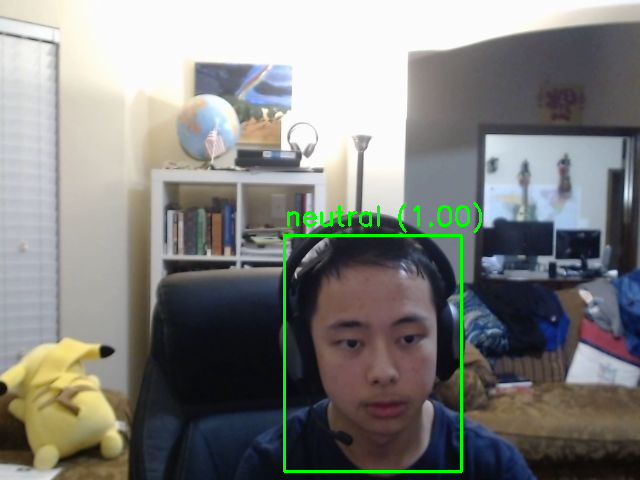

In [40]:
import base64
from PIL import Image
import numpy as np
import torch
import torchvision
from torchvision import transforms
from IPython.display import display, Javascript, update_display, Image as IPyImage
from google.colab.output import register_callback, eval_js
import io
import time

display_id = None

class EmotionDetector:
    def __init__(self, model_type=prediction_args['model_type'], checkpoint_path = get_best_model_path(), num_classes=7, verbose=False):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

        # Initialize MTCNN face detector
        self.mtcnn = MTCNN(
            keep_all=True,
            min_face_size=40,
            thresholds=[0.6, 0.7, 0.7],
            device=self.device
        )

        self.model = self._load_model(model_type, checkpoint_path, num_classes)
        self.transform = self._get_transform(model_type)
        self.verbose = verbose

    def _load_model(self, model_type, checkpoint_path, num_classes):
        if model_type == 'resnet50.a1_in1k':
            backbone = timm.create_model(model_type, pretrained=True, num_classes=0)
            model = EmotionNet(backbone, num_classes)
        else:
            model = MoodCNN2(num_classes=num_classes)

        model.load_state_dict(torch.load(checkpoint_path, map_location=self.device))
        model.to(self.device)
        model.eval()
        return model

    def _get_transform(self, model_type):
        model_timm = timm.create_model(model_type, pretrained=True, num_classes=0)
        config = timm.data.resolve_model_data_config(model_timm)
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            # transforms.Normalize(config['mean'], config['std']),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

    def predict_emotion(self, image: Image.Image):
        # Convert to RGB if needed
        # if image.mode != 'RGB':
        #     image = image.convert('RGB')

        image = image.convert('L')
        image = image.convert('RGB')  # Fake 3-channel so transform won't break

        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Detect faces with MTCNN
        boxes, _ = self.mtcnn.detect(image)

        if boxes is None or len(boxes) == 0:
            return "No face detected", None, None

        # Process first detected face
        x1, y1, x2, y2 = map(int, boxes[0])
        w, h = x2 - x1, y2 - y1

        # Expand bounding box by 20%
        x1 = max(0, int(x1 - 0.2 * w))
        y1 = max(0, int(y1 - 0.2 * h))
        x2 = min(image.width, int(x2 + 0.2 * w))
        y2 = min(image.height, int(y2 + 0.2 * h))

        face_crop = image.crop((x1, y1, x2, y2))
        face_tensor = self.transform(face_crop).unsqueeze(0).to(self.device)

        with torch.no_grad():
            output = self.model(face_tensor)
            probs = torch.softmax(output, dim=1)
            confidence, predicted = torch.max(probs, 1)
            return self.class_names[predicted.item()], confidence.item(), (x1, y1, x2, y2)

    def start_webcam(self):
        # Clear previous webcam instances
        display(Javascript('''
            if (window.stream) {
                window.stream.getTracks().forEach(track => track.stop());
            }
            if (window.video) {
                window.video.remove();
            }
            if (window.canvas) {
                window.canvas.remove();
            }
        '''))

        # Simplified webcam capture
        js = """
        async function capture() {
            const video = document.createElement('video');
            video.style.transform = 'scaleX(-1)';
            document.body.appendChild(video);
            video.width = 640;
            video.height = 480;

            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await video.play();

            const canvas = document.createElement('canvas');
            canvas.width = video.width;
            canvas.height = video.height;
            const ctx = canvas.getContext('2d');
            ctx.translate(canvas.width, 0);
            ctx.scale(-1, 1);

            function captureFrame() {
                ctx.drawImage(video, 0, 0, canvas.width, canvas.height);
                const data = canvas.toDataURL('image/jpeg', 0.8);
                google.colab.kernel.invokeFunction('notebook.get_frame', [data], {});
                setTimeout(captureFrame, 100);
            }
            captureFrame();
        }
        capture();
        """
        display(Javascript(js))



def get_frame(data):
        global display_id
        try:
            # Decode base64 image
            img_bytes = base64.b64decode(data.split(',')[1])
            img_np = np.frombuffer(img_bytes, dtype=np.uint8)
            frame = cv2.imdecode(img_np, cv2.IMREAD_COLOR)

            # Convert to PIL for processing
            pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

            # Predict emotion
            emotion, conf, box = detector.predict_emotion(pil_image)

            # Draw results on frame
            if emotion != "No face detected" and box is not None:
                x1, y1, x2, y2 = box
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, f"{emotion} ({conf:.2f})", (x1, y1-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
            else:
                cv2.putText(frame, "No face detected", (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

            # Display image
            _, buffer = cv2.imencode('.png', frame)
            display_img = IPyImage(data=buffer.tobytes())

            if display_id is None:
                display_id = display(display_img, display_id=True)
            else:
                # update_display(display_img, display_id=display_id)
                display_id.update(display_img)

        except Exception as e:
            print(f"Error in get_frame: {str(e)}")

if __name__ == "__main__":
        # Initialize detector (adjust paths as needed)
        detector = EmotionDetector(
            # model_type=args.model_name,
            prediction_args['model_type'],
            num_classes=7,
            verbose=False
        )

        # Test with a sample image first
        # try:
        #     from google.colab import files
        #     print("Upload a test image for verification")
        #     uploaded = files.upload()
        #     if uploaded:
        #         file_name = next(iter(uploaded))
        #         test_image = Image.open(file_name)

        #         # Display test image
        #         print(f"Testing with: {file_name}")
        #         display(test_image)

        #         # Predict emotion
        #         emotion, conf, box = detector.predict_emotion(test_image)
        #         print(f"Test Result: {emotion} (Confidence: {conf:.2f})")
        # except Exception as e:
        #     print(f"Static test skipped: {e}")

        # Start webcam
        # register_callback('notebook.get_frame', get_frame)
        # detector.start_webcam()